In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
img_size=224
# Directory paths
base_dir = "/kaggle/input/plant-disease-classification-merged-dataset"
classes = os.listdir(base_dir)
print('No of Classes : ',len(classes))

No of Classes :  88


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 63302 images belonging to 88 classes.
Found 15784 images belonging to 88 classes.


In [ ]:
train_data = (
                 train_data
                 .shuffle(buffer_size=8, reshuffle_each_iteration = True)
                 .prefetch(tf.data.AUTOTUNE)
                 )

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
base_model.trainable = True

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(88, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
metrics = [
    CategoricalAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 88)                180312    
                                                                 
Total params: 21,983,096
Trainable params: 21,948,664
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience= 2, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=4,
                    batch_size=16,
                    callbacks=callbacks)

Epoch 1/4
3957/3957 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.8298 - precision: 0.9038 - recall: 0.7767 - auc: 0.9944
Epoch 1: val_accuracy improved from -inf to 0.87107, saving model to best_model.h5
3957/3957 [==============================] - 2169s 536ms/step - loss: 0.5698 - accuracy: 0.8298 - precision: 0.9038 - recall: 0.7767 - auc: 0.9944 - val_loss: 0.4110 - val_accuracy: 0.8711 - val_precision: 0.9095 - val_recall: 0.8447 - val_auc: 0.9947
Epoch 2/4
3957/3957 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9072 - precision: 0.9335 - recall: 0.8865 - auc: 0.9976
Epoch 2: val_accuracy improved from 0.87107 to 0.89534, saving model to best_model.h5
3957/3957 [==============================] - 1961s 496ms/step - loss: 0.2839 - accuracy: 0.9072 - precision: 0.9335 - recall: 0.8865 - auc: 0.9976 - val_loss: 0.3527 - val_accuracy: 0.8953 - val_precision: 0.9194 - val_recall: 0.8795 - val_auc: 0.9934
Epoch 3/4
3957/3957 [==========

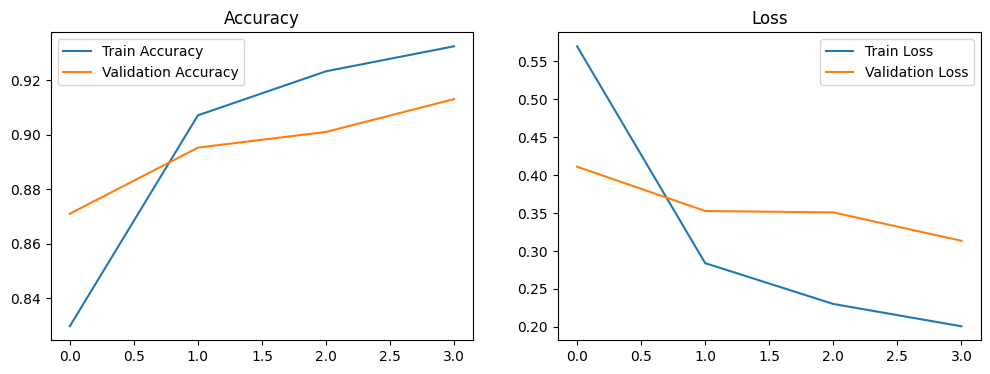

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()